## Description

In this competition, participants will work with four datasets: training, validation, test, and comp_test. The training dataset contains labeled data that competitors will use to train their models. The validation dataset allows them to fine-tune their models and assess performance during development. The test dataset provides an additional benchmark to estimate how well their models generalize to unseen data. However, the comp_test dataset is different—it consists of unlabeled data for which participants must generate predictions. Their final task is to submit predictions for this dataset, which will be evaluated against hidden ground-truth labels to determine the competition rankings.

In [1]:
# Import deep learning libraries
import os #para que funcione bien en windows, linux y mac
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset,Dataset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # Añadido para visualización
from tqdm import tqdm

# **Paso 1: Separacion de datos y preprocesamiento** 

## Pipeline de Preprocesamiento de Imágenes

La canalización de transformación está diseñada para preprocesar las imágenes antes de alimentarlas al modelo, siguiendo los requisitos de la competencia. Los pasos involucrados son:

1. **Convertir a escala de grises**:  
   `transforms.Grayscale(num_output_channels=1)` asegura que todas las imágenes tengan un solo canal, reduciendo la complejidad y enfocándose en las características estructurales.

2. **Redimensionar a una dimensión fija**:  
   `transforms.Resize((150, 150))` ajusta todas las imágenes a un tamaño estándar de **150x150 píxeles**, tal como lo requiere la línea base de la competencia.

3. **Convertir a Tensor**:  
   `transforms.ToTensor()` convierte las imágenes en **tensores de PyTorch**, normalizando los valores de los píxeles al rango $[0, 1]$.

4. **Normalizar valores de píxeles**:  
   `transforms.Normalize(mean=[0.5], std=[0.5])` estandariza los valores de los píxeles para que tengan una **media de cero** y un rango aproximadamente de $[-1, 1]$, estabilizando el proceso de entrenamiento.

Este preprocesamiento garantiza la uniformidad en los conjuntos de datos de **entrenamiento (train)**, **validación (val)**, **prueba (test)** y el set ciego de la competencia (**comp_test**).

In [2]:
# Define the transformations (Requisito de competencia: 1 canal, 150x150)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((150, 150)),                
    transforms.ToTensor(),                        
    transforms.Normalize(mean=[0.5], std=[0.5])   
])

## Preparación del Dataset de Entrenamiento

1. **Ruta**: Se utiliza el directorio local `data/seg_train` con imágenes organizadas por carpetas de clase.
2. **Carga**: `datasets.ImageFolder` automatiza el etiquetado y aplica las transformaciones de preprocesamiento.
3. **Batch Size**: Se define un tamaño de lote de `32` para procesar imágenes en grupos durante el entrenamiento.
4. **DataLoader**: `DataLoader(shuffle=True)` crea un iterable que mezcla los datos en cada época para mejorar la generalización y evitar el sobreajuste.

In [3]:
# train dataset local
base_path = 'data'
train_path = os.path.join(base_path, 'seg_train')

# Cargamos usando ImageFolder
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Verificación inicial
for images, labels in train_loader:
    print(f"Dimensiones del batch: {images.shape}") # Debe ser [32, 1, 150, 150]
    print(f"Etiquetas del batch: {labels.shape}")
    break

Dimensiones del batch: torch.Size([32, 1, 150, 150])
Etiquetas del batch: torch.Size([32])


## Visualización de Imágenes del Dataset de Entrenamiento

Este bloque recupera un lote de imágenes del `train_loader`, las desnormaliza y las grafica para inspeccionar visualmente los datos.

1. **Iteración**: Se extrae un lote de `images` y `labels` del cargador de datos.
2. **Desnormalización**: Se revierte la normalización (`images * 0.5 + 0.5`) para devolver los píxeles al rango original $[0,1]$ y visualizarlos correctamente.
3. **Graficación**: 
   - Se crea una cuadrícula de 3x3 para mostrar las primeras 9 imágenes.
   - Se usa `cmap='gray'` para representar correctamente el canal único de gris.
   - Se asigna el título con la etiqueta correspondiente y se ocultan los ejes.
4. **Finalización**: Se utiliza `break` para procesar únicamente el primer lote.

Esta visualización permite verificar que el preprocesamiento (escala de grises y redimensionamiento) se aplicó correctamente antes de iniciar el entrenamiento.

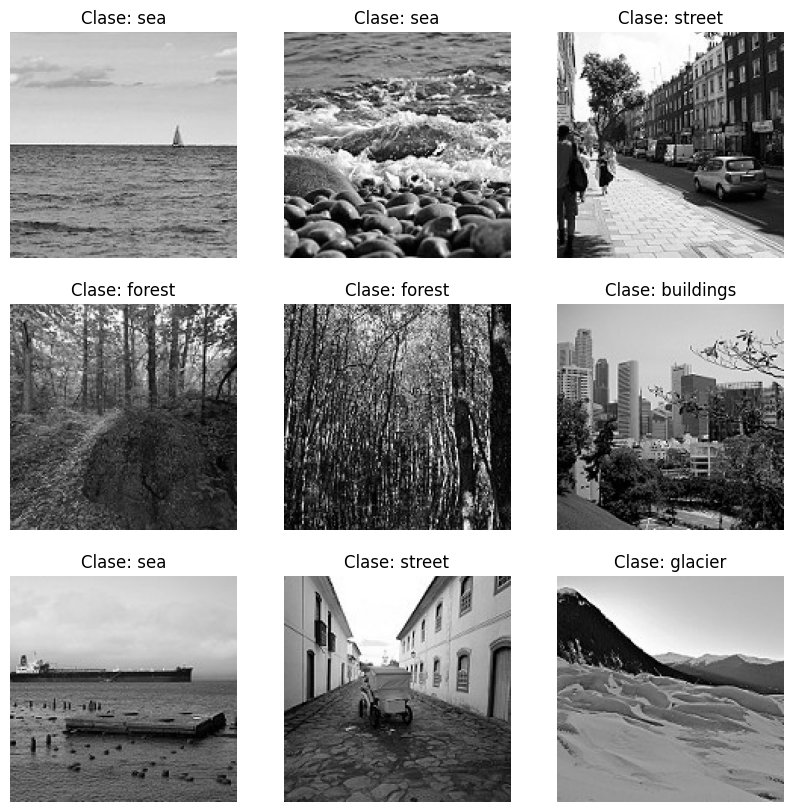

In [4]:
# Check some examples
for images, labels in train_loader:
    # Desnormalizar para visualización (0.5*2 + 0.5 = 1.0)
    images_plot = images * 0.5 + 0.5

    plt.figure(figsize=(10, 10))
    for i in range(9):  
        ax = plt.subplot(3, 3, i + 1)
        # Mostramos el canal 0 (gris)
        plt.imshow(images_plot[i][0], cmap='gray')  
        plt.title(f"Clase: {train_dataset.classes[labels[i].item()]}")
        plt.axis('off')
    plt.show()
    break

## Preparación de Datasets de Validación y Test con Muestreo Estratificado

En esta sección, cargamos el dataset de validación, aplicamos un muestreo estratificado para asegurar el equilibrio entre clases y creamos conjuntos separados de **validación** y **test**.

1. **Carga del Dataset Completo**:  
   Se utiliza el directorio local `data/seg_test` y se aplican las mismas transformaciones que en el entrenamiento. Los objetivos (targets) se convierten en un arreglo de NumPy para el proceso de estratificación.

2. **Muestreo Estratificado**:  
   Mediante `StratifiedShuffleSplit`, se garantiza que cada subconjunto mantenga la misma distribución de clases que el dataset original. Se generan dos muestras no solapadas: una para **validación** y otra para **prueba**.

3. **Asignación de Subconjuntos**:  
   - El primer subconjunto se asigna como **dataset de validación** (usado para ajustar hiperparámetros).  
   - El segundo subconjunto se asigna como **dataset de test** (usado para la evaluación final interna).

4. **DataLoaders**:  
   Se crean cargadores con un `batch_size` de `100` y `shuffle=False` para mantener la consistencia en el orden y la distribución estratificada durante la evaluación.

**Propósito**: Este enfoque evita sesgos de clase y asegura que la evaluación del modelo sea justa y representativa antes de realizar la inferencia en los datos de la competencia.

In [5]:
# Validation and test data local
val_path = os.path.join(base_path, 'seg_test')
val_dataset_full = datasets.ImageFolder(root=val_path, transform=transform)

targets = np.array(val_dataset_full.targets)  
sample_size = 100  # Tamaño de cada muestra

num_iterations = 2  
# Split estratificado para mantener la proporción de las 6 clases
splitter = StratifiedShuffleSplit(n_splits=num_iterations, test_size=sample_size, random_state=42)

sample_datasets = []
for _, sample_idx in splitter.split(np.zeros(len(targets)), targets):
    sample_datasets.append(Subset(val_dataset_full, sample_idx))

# Asignamos los subconjuntos
val_dataset = sample_datasets[0]
test_dataset = sample_datasets[1]

# DataLoaders para validación y test
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset de validación: {len(val_dataset)} imágenes")
print(f"Dataset de prueba interno: {len(test_dataset)} imágenes")

Dataset de validación: 100 imágenes
Dataset de prueba interno: 100 imágenes


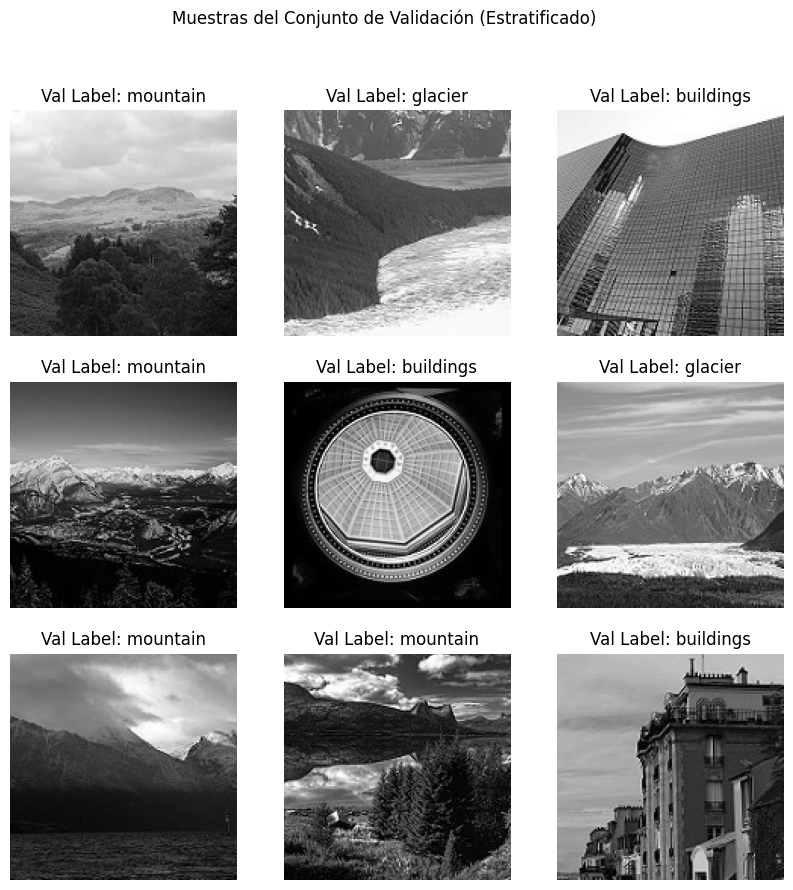

In [6]:
# Check some examples of the validation data
for images, labels in val_loader:
    # Desnormalizar las imágenes para la visualización
    images_val = images * 0.5 + 0.5

    # Graficar las imágenes
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Graficar 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        # Usamos images_val[i][0] para mostrar el único canal de gris
        plt.imshow(images_val[i][0], cmap='gray')  
        # Mostramos el nombre de la clase usando el índice de la etiqueta
        plt.title(f"Val Label: {train_dataset.classes[labels[i].item()]}")
        plt.axis('off')
    plt.suptitle("Muestras del Conjunto de Validación (Estratificado)")
    plt.show()
    break

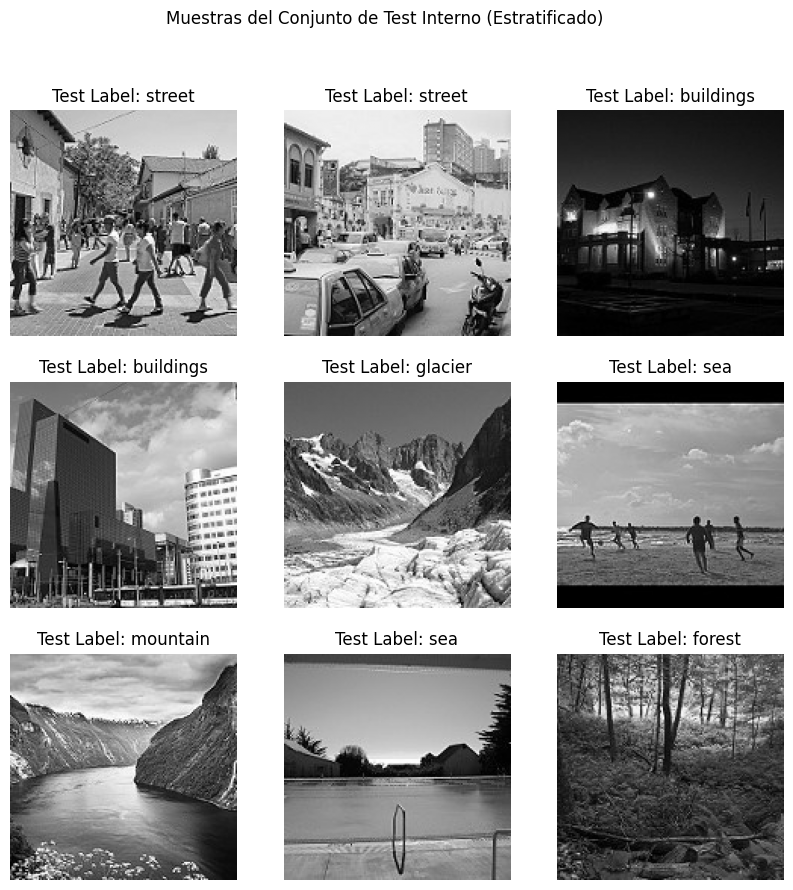

In [7]:
# Check some examples of the test data
for images, labels in test_loader:
    # Desnormalizar las imágenes para la visualización
    images_test = images * 0.5 + 0.5

    # Graficar las imágenes
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Graficar 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_test[i][0], cmap='gray')  
        plt.title(f"Test Label: {train_dataset.classes[labels[i].item()]}")
        plt.axis('off')
    plt.suptitle("Muestras del Conjunto de Test Interno (Estratificado)")
    plt.show()
    break

## Preparación del Dataset de Competencia (Prueba Ciega)

Esta sección crea el conjunto de datos para las imágenes de la competencia (`comp_test`), las cuales no tienen etiquetas. El objetivo es preparar estas imágenes para la inferencia y generar el archivo de predicciones finales.

1. **Listado de Archivos**:  
   Se accede al directorio local `data/seg_pred` y se filtran únicamente los archivos con extensiones válidas (`.png`, `.jpg`, `.jpeg`).

2. **Selección de Imágenes**:  
   Se selecciona un subconjunto de imágenes (por ejemplo, las primeras 200) para validar que el flujo de inferencia funciona correctamente antes de procesar el set completo.

3. **Dataset Personalizado (`SelectedFilesDataset`)**:  
   - Se implementó una clase que hereda de `Dataset` para manejar imágenes sin etiquetas.
   - **Conversión a Gris**: A diferencia del estándar RGB, las imágenes se convierten a escala de grises (`"L"`) para coincidir con el entrenamiento del modelo.
   - El método `__getitem__` devuelve tanto la imagen procesada como su **nombre de archivo**, lo cual es indispensable para el ID de la entrega final.

4. **DataLoader de Inferencia**:  
   Se configura con un `batch_size` adecuado y `shuffle=False` para asegurar que las predicciones mantengan el orden de los nombres de archivo.

Este proceso garantiza que los datos ciegos reciban exactamente el mismo tratamiento de preprocesamiento que los datos de entrenamiento.

In [8]:
# Paso 1: Listar imágenes en el directorio local
# CAMBIO: Usamos la ruta local 'data/seg_pred' definida anteriormente
image_directory = os.path.join('data', 'seg_pred') 
image_files = os.listdir(image_directory)

# Filtrar extensiones de imagen
image_files = [f for f in image_files if f.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Paso 2: Seleccionar las primeras 200 imágenes (para prueba rápida)
image_files = image_files[:200]

class SelectedFilesDataset(Dataset):
    def __init__(self, root_dir, file_names, transform=None):
        self.root_dir = root_dir
        self.file_names = file_names
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_names[idx])
        
        # CAMBIO: .convert("L") en lugar de "RGB" porque la competencia exige escala de grises (1 canal)
        image = Image.open(file_path).convert("L")  

        if self.transform:
            image = self.transform(image)

        return image, self.file_names[idx] 

# Uso del dataset
# CAMBIO: Asegúrate de usar el 'transform' que definimos al principio (150x150, Gray, Normalize)
comp_test_dataset = SelectedFilesDataset(image_directory, image_files, transform=transform)

# CAMBIO: batch_size=32 para mantener consistencia con el entrenamiento, aunque 100 también funciona para inferencia
comp_test_loader = DataLoader(comp_test_dataset, batch_size=32, shuffle=False) 

# Verificación
for images, names in comp_test_loader:
    print(f"Batch de competencia: {images.shape}") # Debe ser [Batch, 1, 150, 150]
    print(f"Primer archivo: {names[0]}")
    break

Batch de competencia: torch.Size([32, 1, 150, 150])
Primer archivo: 10004.jpg


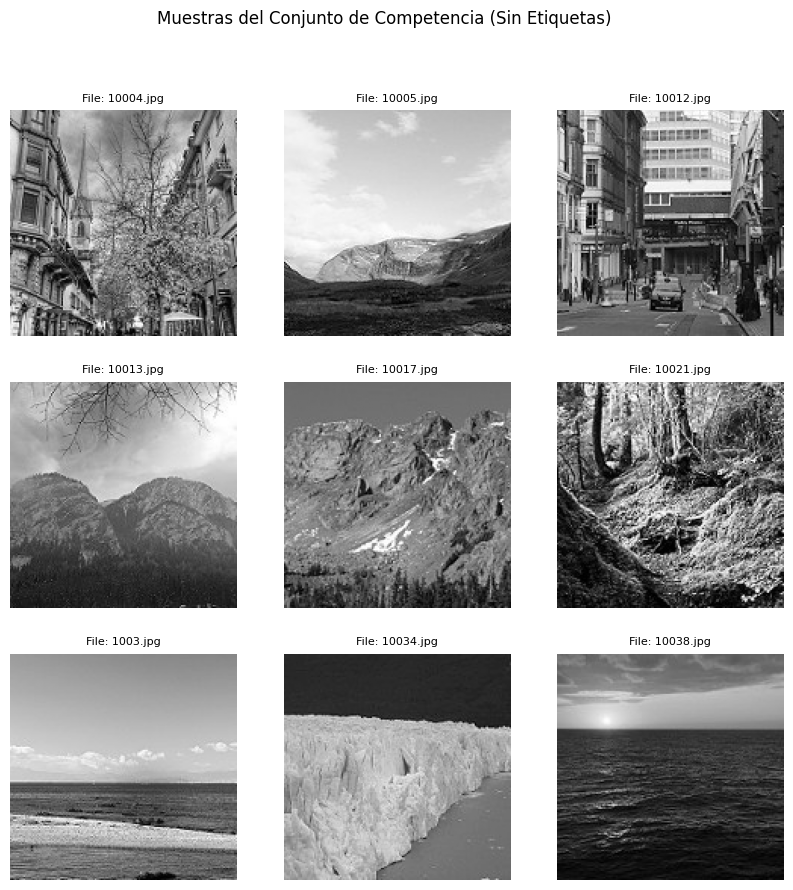

In [19]:
# Check some examples of the competition test data
for images, filenames in comp_test_loader:
    # Desnormalizar las imágenes para la visualización
    images_comp = images * 0.5 + 0.5

    # Graficar las imágenes
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(filenames))):  # Graficar hasta 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        # Mostramos el canal 0 (gris)
        plt.imshow(images_comp[i][0], cmap='gray')  
        
        # CAMBIO: Mostramos el nombre del archivo como título para verificar la carga
        plt.title(f"File: {filenames[i]}", fontsize=8)
        plt.axis('off')
    
    plt.suptitle("Muestras del Conjunto de Competencia (Sin Etiquetas)")
    plt.show()
    break

## Paso 2: Configuración del Entrenamiento del Modelo

Este paso se centra en definir la **arquitectura del modelo**, establecer la **función de pérdida**, el **optimizador** y crear el **bucle de entrenamiento**.

### Definición de la Arquitectura
Se utiliza una Red Neuronal Convolucional (CNN) diseñada para procesar imágenes en escala de grises de $150 \times 150$ píxeles. Esta arquitectura es ideal para capturar patrones espaciales en imágenes de paisajes y clasificarlas en las 6 categorías del dataset.

In [20]:
# Configuración del hardware
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Corriendo en: {device}")

# Definición de la arquitectura (CNN para 6 clases)
class IntelCNN(nn.Module):
    def __init__(self):
        super(IntelCNN, self).__init__()
        
        # Bloque 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Bloque 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Bloque 3 (La nueva capa)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Ajustamos la entrada de la capa lineal (ahora son 128 filtros)
        self.fc1 = nn.Linear(128 * 7 * 7, 256) # Subimos a 256 para manejar más info
        self.fc2 = nn.Linear(256, 6)
        
        self.dropout = nn.Dropout(0.4) # Subimos un poco el dropout para evitar el sobreajuste

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x))) # Aplicamos la tercera capa
        
        x = self.adaptive_pool(x)
        x = x.view(-1, 128 * 7 * 7)
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Inicializar modelo, pérdida y optimizador
model = IntelCNN().to(device)


print("Modelo listo para el entrenamiento.")

Corriendo en: cuda
Modelo listo para el entrenamiento.


### **2. Define the Loss Function and Optimizer**
- The **loss function** (e.g., `CrossEntropyLoss`) measures how well the model's predictions match the true labels.
- The **optimizer** (e.g.,`SGD`) updates the model’s parameters to minimize the loss.

In [22]:
# Definir la función de pérdida y el optimizador
# Usamos CrossEntropyLoss porque tenemos 6 clases de paisajes
criterion = nn.CrossEntropyLoss()

# Usamos Adam como optimizador con una tasa de aprendizaje de 0.001
# Es el estándar para este tipo de redes convolucionales
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Número de épocas para el entrenamiento
epochs = 20

print("Configuración de pérdida y optimizador lista.")

Configuración de pérdida y optimizador lista.


### **3. Training Loop**
The model is trained iteratively using:
1. **Forward pass** – The model makes predictions.
2. **Loss computation** – The difference between predictions and actual labels is calculated.
3. **Backward pass** – Gradients are computed via backpropagation.
4. **Parameter update** – The optimizer updates model weights to minimize loss.
5. **Evaluation on the validation set** – The model’s performance is monitored to avoid overfitting.

In [23]:
# Listas para guardar el progreso y graficar después si quieres
train_losses = []
val_accuracies = []

print(f"Iniciando entrenamiento en {device}...")

for epoch in range(epochs):
    # --- FASE DE ENTRENAMIENTO ---
    model.train()
    running_loss = 0.0
    
    # tqdm nos ayuda a ver la velocidad de la GPU en tiempo real
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        # 1. Forward pass
        outputs = model(images)
        
        # 2. Loss computation
        loss = criterion(outputs, labels)
        
        # 3. Backward pass (Gradients)
        optimizer.zero_grad()
        loss.backward()
        
        # 4. Parameter update
        optimizer.step()
        
        running_loss += loss.item()
    
    # --- FASE DE VALIDACIÓN (EVALUACIÓN) ---
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Guardar resultados
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * val_correct / val_total
    train_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)
    
    print(f"Resultado -> Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.2f}%")

print("¡Entrenamiento terminado!")

Iniciando entrenamiento en cuda...


Epoch 1/20: 100%|██████████| 439/439 [01:31<00:00,  4.81it/s]


Resultado -> Loss: 1.0226 | Val Acc: 69.00%


Epoch 2/20: 100%|██████████| 439/439 [00:21<00:00, 20.46it/s]


Resultado -> Loss: 0.7126 | Val Acc: 79.00%


Epoch 3/20: 100%|██████████| 439/439 [00:24<00:00, 17.87it/s]


Resultado -> Loss: 0.5827 | Val Acc: 82.00%


Epoch 4/20: 100%|██████████| 439/439 [00:21<00:00, 20.29it/s]


Resultado -> Loss: 0.5240 | Val Acc: 82.00%


Epoch 5/20: 100%|██████████| 439/439 [00:22<00:00, 19.74it/s]


Resultado -> Loss: 0.4640 | Val Acc: 88.00%


Epoch 6/20: 100%|██████████| 439/439 [00:22<00:00, 19.80it/s]


Resultado -> Loss: 0.4221 | Val Acc: 85.00%


Epoch 7/20: 100%|██████████| 439/439 [00:22<00:00, 19.74it/s]


Resultado -> Loss: 0.3889 | Val Acc: 79.00%


Epoch 8/20: 100%|██████████| 439/439 [00:22<00:00, 19.62it/s]


Resultado -> Loss: 0.3465 | Val Acc: 81.00%


Epoch 9/20: 100%|██████████| 439/439 [00:23<00:00, 18.75it/s]


Resultado -> Loss: 0.3115 | Val Acc: 89.00%


Epoch 10/20: 100%|██████████| 439/439 [00:23<00:00, 18.52it/s]


Resultado -> Loss: 0.2903 | Val Acc: 83.00%


Epoch 11/20: 100%|██████████| 439/439 [00:23<00:00, 18.68it/s]


Resultado -> Loss: 0.2530 | Val Acc: 87.00%


Epoch 12/20: 100%|██████████| 439/439 [00:24<00:00, 18.22it/s]


Resultado -> Loss: 0.2180 | Val Acc: 86.00%


Epoch 13/20: 100%|██████████| 439/439 [00:24<00:00, 18.17it/s]


Resultado -> Loss: 0.1945 | Val Acc: 85.00%


Epoch 14/20: 100%|██████████| 439/439 [00:25<00:00, 17.56it/s]


Resultado -> Loss: 0.1780 | Val Acc: 84.00%


Epoch 15/20: 100%|██████████| 439/439 [00:24<00:00, 18.21it/s]


Resultado -> Loss: 0.1620 | Val Acc: 86.00%


Epoch 16/20: 100%|██████████| 439/439 [00:22<00:00, 19.11it/s]


Resultado -> Loss: 0.1310 | Val Acc: 84.00%


Epoch 17/20: 100%|██████████| 439/439 [00:22<00:00, 19.53it/s]


Resultado -> Loss: 0.1245 | Val Acc: 87.00%


Epoch 18/20: 100%|██████████| 439/439 [00:22<00:00, 19.57it/s]


Resultado -> Loss: 0.1111 | Val Acc: 82.00%


Epoch 19/20: 100%|██████████| 439/439 [00:22<00:00, 19.37it/s]


Resultado -> Loss: 0.1084 | Val Acc: 85.00%


Epoch 20/20: 100%|██████████| 439/439 [00:23<00:00, 18.97it/s]


Resultado -> Loss: 0.1023 | Val Acc: 87.00%
¡Entrenamiento terminado!


### **4. Model Evaluation on Test Set**

After training, the model's performance is assessed on the test dataset to evaluate its generalization to unseen data. This involves computing the loss and accuracy without updating model parameters, ensuring an unbiased estimate of its predictive capabilities.


In [25]:
# --- EVALUACIÓN EN EL TEST SET INTERNO ---
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

print("Evaluando el modelo en el set de prueba interno...")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Inferencia
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Cálculo de precisión
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f"\nResultados en Test Set:")
print(f"Loss: {avg_test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

Evaluando el modelo en el set de prueba interno...

Resultados en Test Set:
Loss: 0.4699
Accuracy: 84.00%


### **5. Generating Predictions for the Competition Test Set**

After training and validating the model, the next step is to generate predictions for the comp_test dataset, which contains unlabeled data. This involves processing the dataset through the trained model to obtain predicted labels. These predictions are then formatted according to the competition's submission requirements, a CSV file with each image's filename and its corresponding predicted label. This submission file is then uploaded to the competition platform for evaluation against the hidden ground-truth labels.


In [17]:
preds = []
ids = []

model.eval() # 1. Cambio: Asegurar modo evaluación

with torch.no_grad():
    for images, names in comp_test_loader:
        # 2. Cambio: Quitamos el .view()
        # Las CNN necesitan la imagen 4D [Batch, 1, 150, 150], no plana.
        X = images.to(device)

        # 3. Cambio: Usamos 'model' en lugar de 'net'
        Z = model(X) 
        
        _, predicted = torch.max(Z, 1)
        
        # 4. Cambio: Guardamos los datos asegurando que sean listas
        preds.append(predicted.detach().cpu().numpy().tolist())
        ids.append(list(names))

In [18]:
import pandas as pd

ids = sum(ids,[])
preds = sum(preds,[])


# Ensure file_names and pred have the same length
if len(ids) != len(preds):
    raise ValueError("The length of file_names and pred must be the same.")

# Create a DataFrame from the file_names and pred lists
df = pd.DataFrame({
    'id': ids,
    'pred': preds
})

# Define the CSV file name
csv_file = 'predictions.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file, index=False)

print(f"CSV file '{csv_file}' created successfully.")

CSV file 'predictions.csv' created successfully.


The file can be downloaded from the folder /kaggle/working